# Testing bilateral symmetry
This notebook describes a first pass at testing for some notion of bilateral symmetry.
Here, we focus only on the left-left and right-right induced subgraphs for simplicity.
We also use the unweighted version of the maggot connectomes. Also, for now, we
restrict ourselves to the set of neurons for which we know a pairing between neuron A
on the left hemisphere and neuron A on the right hemisphere.

To summarize, this notebook presents a strange phenomena where depending on the
dimension of the embedding that we use to test bilateral symmetry, we get vastly
different results.

We also present a modified proceedure that fails to reject the null that the latent
positions of the left-left induced subgraph and the right-right induced subgraph have
the same distribution over many embedding dimensions, suggesting that for the current
setup we fail to reject bilateral symmetry.

## Preliminaries

In [1]:
from pkg.utils import set_warnings

set_warnings()

from datetime import timedelta
import pprint
import time


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hyppo.ksample import KSample
from scipy.stats import ks_2samp

from graspologic.align import OrthogonalProcrustes, SeedlessProcrustes
from graspologic.embed import AdjacencySpectralEmbed, select_dimension
from graspologic.plot import pairplot
from graspologic.utils import (
    augment_diagonal,
    binarize,
    multigraph_lcc_intersection,
    pass_to_ranks,
)
from pkg.data import load_adjacency, load_node_meta
from pkg.io import savefig
from pkg.plot import set_theme
from pkg.utils import get_paired_inds, get_paired_subgraphs

from src.visualization import adjplot  # TODO fix graspologic version and replace here

t0 = time.time()


def stashfig(name, **kwargs):
    foldername = "bilateral_symmetry"
    savefig(name, foldername=foldername, **kwargs)


colors = sns.color_palette("Set1")
palette = dict(zip(["Left", "Right", "OP", "O-SP"], colors))
set_theme()

## Load the data

### Load node metadata and select the subgraphs of interest

In [2]:
meta = load_node_meta()
meta = meta[meta["paper_clustered_neurons"]]

adj = load_adjacency(graph_type="G", nodelist=meta.index)

lp_inds, rp_inds = get_paired_inds(meta)
left_meta = meta.iloc[lp_inds]
right_meta = meta.iloc[rp_inds]

ll_adj, rr_adj, lr_adj, rl_adj = get_paired_subgraphs(adj, lp_inds, rp_inds)

# TODO not sure what we wanna do about LCCs here
adjs, lcc_inds = multigraph_lcc_intersection([ll_adj, rr_adj], return_inds=True)
ll_adj = adjs[0]
rr_adj = adjs[1]
print(f"{len(lcc_inds)} in intersection of largest connected components.")

print(f"Original number of valid pairs: {len(lp_inds)}")

left_meta = left_meta.iloc[lcc_inds]
right_meta = right_meta.iloc[lcc_inds]
meta = pd.concat((left_meta, right_meta))
n_pairs = len(ll_adj)

print(f"Number of pairs after taking LCC intersection: {n_pairs}")

1148 in intersection of largest connected components.
Original number of valid pairs: 1149
Number of pairs after taking LCC intersection: 1148


### Plotting the aligned adjacency matrices
At a high level, we see that the left-left and right-right induced subgraphs look
quite similar when aligned by the known neuron pairs.
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
adjplot(
    ll_adj,
    plot_type="scattermap",
    sizes=(1, 2),
    ax=axs[0],
    title=r"Left $\to$ left",
    color=palette["Left"],
)
adjplot(
    rr_adj,
    plot_type="scattermap",
    sizes=(1, 2),
    ax=axs[1],
    title=r"Right $\to$ right",
    color=palette["Right"],
)
stashfig("left-right-induced-adjs")

## Embedding the graphs
Here I embed the unweighted, directed graphs using ASE.

In [3]:


def plot_latents(left, right, title="", n_show=4):
    plot_data = np.concatenate([left, right], axis=0)
    labels = np.array(["Left"] * len(left) + ["Right"] * len(right))
    pg = pairplot(plot_data[:, :n_show], labels=labels, title=title)
    return pg


def screeplot(sing_vals, elbow_inds, color=None, ax=None, label=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(8, 4))
    plt.plot(range(1, len(sing_vals) + 1), sing_vals, color=color, label=label)
    plt.scatter(
        elbow_inds, sing_vals[elbow_inds - 1], marker="x", s=50, zorder=10, color=color
    )
    ax.set(ylabel="Singular value", xlabel="Index")
    return ax


def embed(adj, n_components=40, ptr=False):
    if ptr:
        adj = pass_to_ranks(adj)
    elbow_inds, elbow_vals = select_dimension(augment_diagonal(adj), n_elbows=4)
    elbow_inds = np.array(elbow_inds)
    ase = AdjacencySpectralEmbed(n_components=n_components)
    out_latent, in_latent = ase.fit_transform(adj)
    return out_latent, in_latent, ase.singular_values_, elbow_inds

### Run the embedding

In [4]:
n_components = 8
max_n_components = 40
preprocess = "binarize"

if preprocess == "binarize":
    ll_adj = binarize(ll_adj)
    rr_adj = binarize(rr_adj)

left_out_latent, left_in_latent, left_sing_vals, left_elbow_inds = embed(
    ll_adj, n_components=max_n_components
)
right_out_latent, right_in_latent, right_sing_vals, right_elbow_inds = embed(
    rr_adj, n_components=max_n_components
)

### Plot the screeplots
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
screeplot(left_sing_vals, left_elbow_inds, color=palette["Left"], ax=ax, label="Left")
screeplot(
    right_sing_vals, right_elbow_inds, color=palette["Right"], ax=ax, label="Right"
)
ax.legend()
ax.axvline(n_components, color="black", linewidth=1.5, linestyle="--")
stashfig(f"screeplot-preprocess={preprocess}")

### Calculating the Frobenius norm of the adjacency matrices
Note that in the screeplot above, the singular values of the right-right subgraph
are always above those of the left-left subgraph (at least for this range of $d$).
This hints as the "scale" of the two graphs. We've noticed that the left-left subgraph
is slightly less dense than the right-right.

It is perhaps worth investigating whether to use the "scaled" version of the
hypothesis test.

In [5]:
print(f"Norm of left-left adjacency: {np.linalg.norm(binarize(ll_adj))}")
print(f"Norm of right-right adjacency: {np.linalg.norm(binarize(rr_adj))}")

Norm of left-left adjacency: 163.6459593146131
Norm of right-right adjacency: 170.35551062410633


### Plot the latent positions of both graphs before alignment

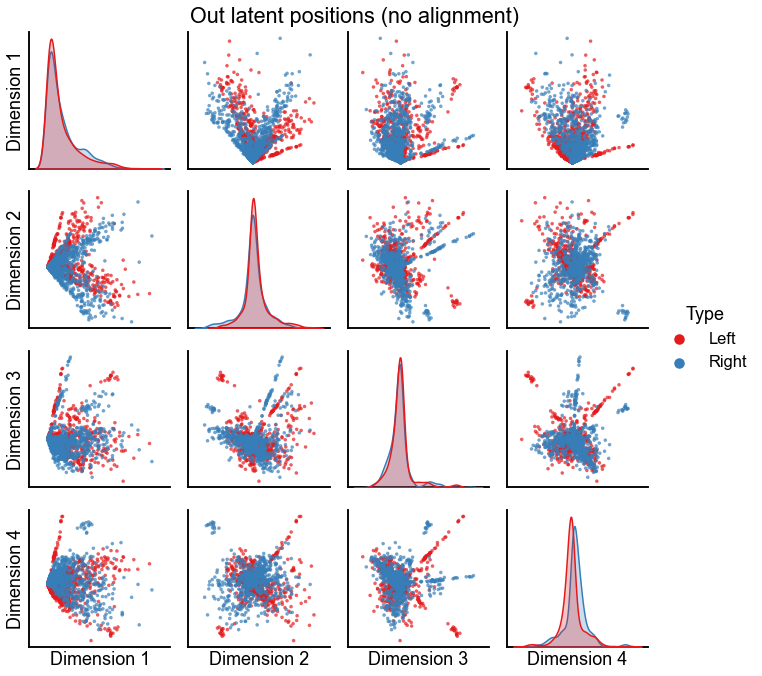

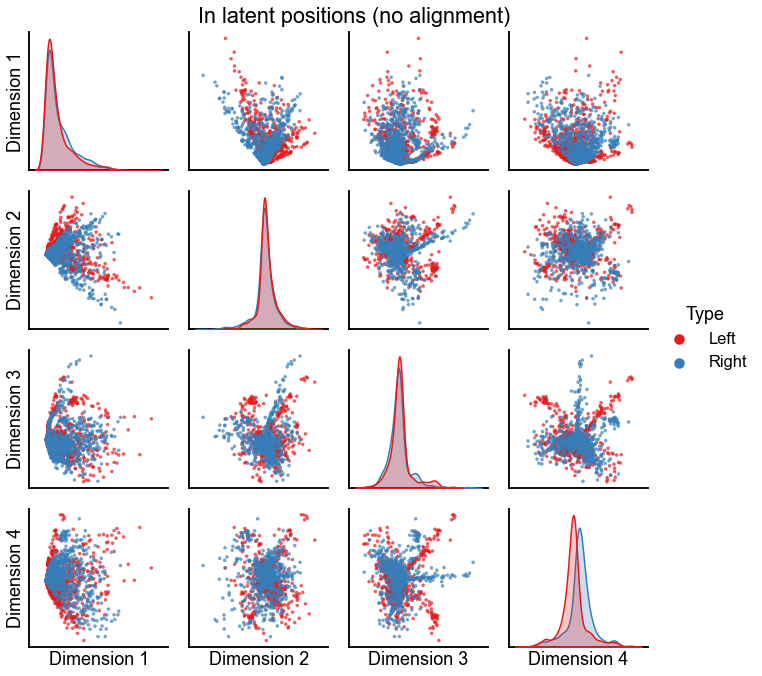

In [6]:
plot_latents(
    left_out_latent, right_out_latent, title="Out latent positions (no alignment)"
)
stashfig(f"out-latent-no-align-preprocess={preprocess}")
plot_latents(
    left_in_latent, right_in_latent, title="In latent positions (no alignment)"
)
stashfig(f"in-latent-no-align-preprocess={preprocess}")

## Align the embeddings
Here we align first using orthogonal Procrustes (OP), and then using
seedless Procrustes initialized at the orthogonal Procrustes solution (O-SP).

I also calculate the Frobenius norm of the difference in the embeddings after
performing the alignment.

In [7]:


def run_alignments(X, Y, scale=False):
    X = X.copy()
    Y = Y.copy()
    if scale:
        X_norm = np.linalg.norm(X, ord="fro")
        Y_norm = np.linalg.norm(Y, ord="fro")
        avg_norms = (X_norm + Y_norm) / 2
        X = X * (avg_norms / X_norm)
        Y = Y * (avg_norms / Y_norm)
    op = OrthogonalProcrustes()
    X_trans_op = op.fit_transform(X, Y)
    sp = SeedlessProcrustes(init="custom", initial_Q=op.Q_)
    X_trans_sp = sp.fit_transform(X, Y)
    return X_trans_op, X_trans_sp


def calc_diff_norm(X, Y):
    return np.linalg.norm(X - Y, ord="fro")

### Plot the alignment for d=8 dimensions

Procrustes diff. norm using true pairs: 4.731981560710599
Seedless Procrustes diff. norm using true pairs: 4.7886788500197035


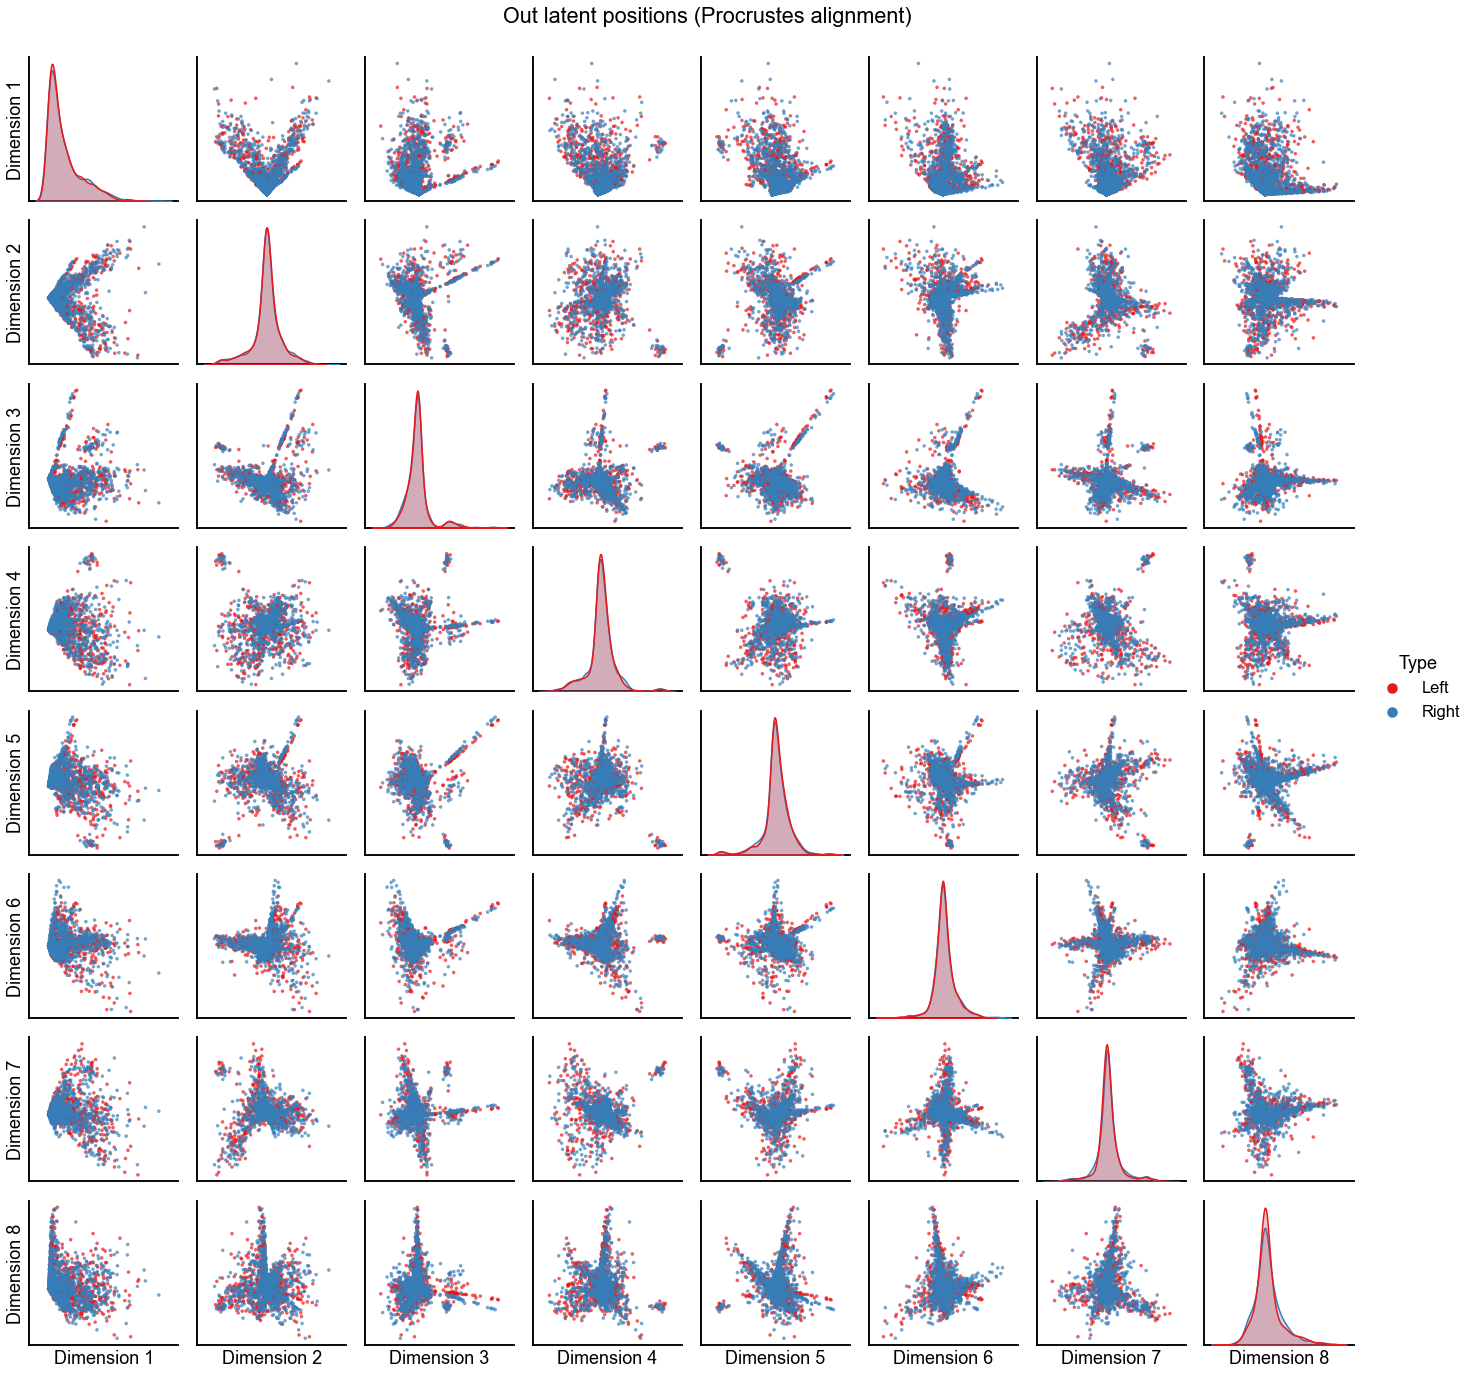

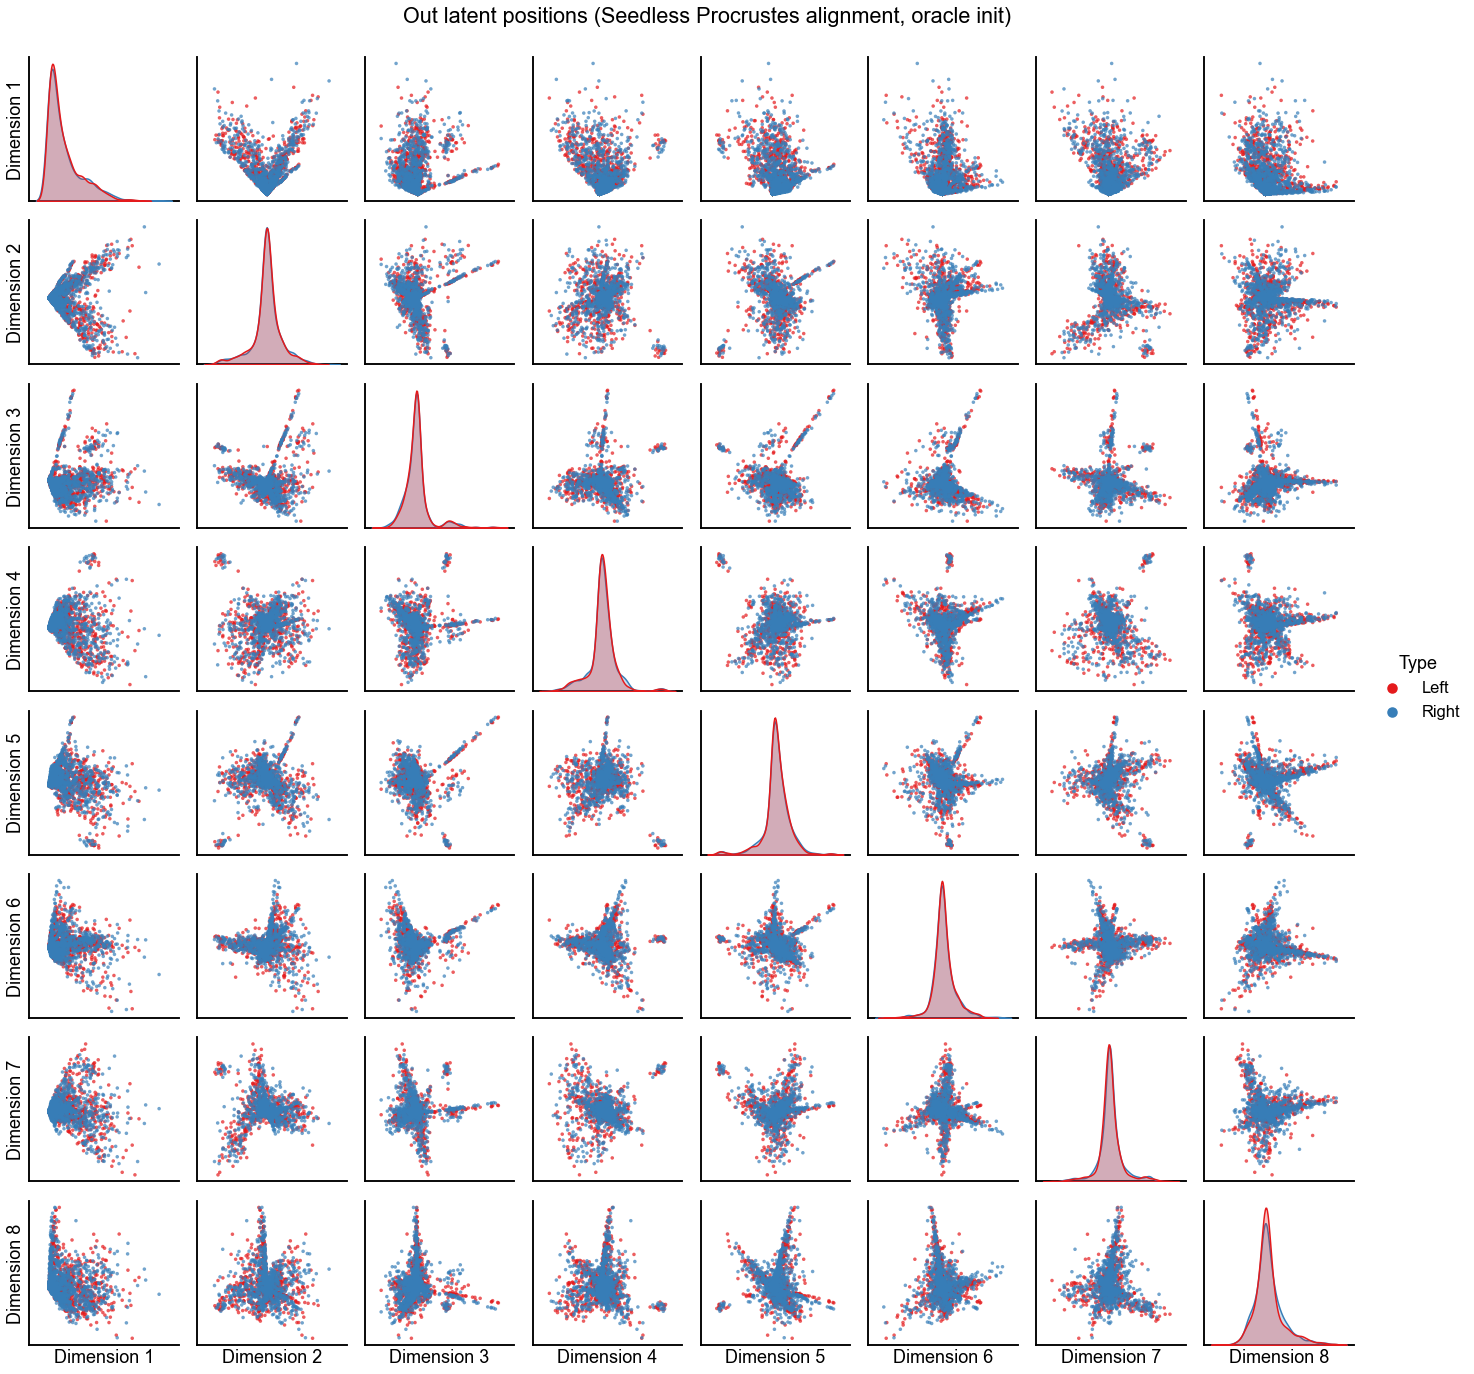

In [8]:
n_components = 8
op_left_out_latent, sp_left_out_latent = run_alignments(
    left_out_latent[:, :n_components], right_out_latent[:, :n_components]
)
op_diff_norm = calc_diff_norm(op_left_out_latent, right_out_latent[:, :n_components])
sp_diff_norm = calc_diff_norm(sp_left_out_latent, right_out_latent[:, :n_components])

print(f"Procrustes diff. norm using true pairs: {op_diff_norm}")
print(f"Seedless Procrustes diff. norm using true pairs: {sp_diff_norm}")

plot_latents(
    op_left_out_latent,
    right_out_latent[:, :n_components],
    "Out latent positions (Procrustes alignment)",
    n_show=n_components,
)
stashfig(f"out-latent-op-preprocess={preprocess}")

plot_latents(
    sp_left_out_latent,
    right_out_latent[:, :n_components],
    "Out latent positions (Seedless Procrustes alignment, oracle init)",
    n_show=n_components,
)
stashfig(f"out-latent-o-sp-n_components={n_components}-preprocess={preprocess}")

### Plot the alignment for d=7 dimensions
n_components = 7
op_left_out_latent, sp_left_out_latent = run_alignments(
    left_out_latent[:, :n_components], right_out_latent[:, :n_components]
)
op_diff_norm = calc_diff_norm(op_left_out_latent, right_out_latent[:, :n_components])
sp_diff_norm = calc_diff_norm(sp_left_out_latent, right_out_latent[:, :n_components])

print(f"Procrustes diff. norm using true pairs: {op_diff_norm}")
print(f"Seedless Procrustes diff. norm using true pairs: {sp_diff_norm}")

plot_latents(
    op_left_out_latent,
    right_out_latent[:, :n_components],
    "Out latent positions (Procrustes alignment)",
    n_show=n_components,
)
stashfig(f"out-latent-op-preprocess={preprocess}")

plot_latents(
    sp_left_out_latent,
    right_out_latent[:, :n_components],
    "Out latent positions (Seedless Procrustes alignment, oracle init)",
    n_show=n_components,
)
stashfig(f"out-latent-o-sp-n_components={n_components}-preprocess={preprocess}")

## Hypothesis testing on the embeddings
To test whether the distribution of latent positions is different, we use the approach
of the "nonpar" test, also called the latent distribution test. Here, for the backend
2-sample test, we use distance correlation (Dcorr).

In [9]:
test = "dcorr"
workers = -1
auto = True
if auto:
    n_bootstraps = None
else:
    n_bootstraps = 500


def run_test(
    X1,
    X2,
    rows=None,
    info={},
    auto=auto,
    n_bootstraps=n_bootstraps,
    workers=workers,
    test=test,
    print_out=False,
):
    currtime = time.time()
    test_obj = KSample(test)
    tstat, pvalue = test_obj.test(
        X1,
        X2,
        reps=n_bootstraps,
        workers=workers,
        auto=auto,
    )
    elapsed = time.time() - currtime
    row = {
        "pvalue": pvalue,
        "tstat": tstat,
        "elapsed": elapsed,
    }
    row.update(info)
    if print_out:
        pprint.pprint(row)
    if rows is not None:
        rows.append(row)
    else:
        return row

### Run the two-sample test for varying embedding dimension

In [10]:

rows = []
for n_components in np.arange(1, 21):
    op_left_out_latent, sp_left_out_latent = run_alignments(
        left_out_latent[:, :n_components], right_out_latent[:, :n_components]
    )
    op_left_in_latent, sp_left_in_latent = run_alignments(
        left_in_latent[:, :n_components], right_in_latent[:, :n_components]
    )
    op_left_composite_latent = np.concatenate(
        (op_left_out_latent, op_left_in_latent), axis=1
    )
    sp_left_composite_latent = np.concatenate(
        (sp_left_out_latent, sp_left_in_latent), axis=1
    )
    right_composite_latent = np.concatenate(
        (right_out_latent[:, :n_components], right_in_latent[:, :n_components]), axis=1
    )

    run_test(
        op_left_composite_latent,
        right_composite_latent,
        rows,
        info={"alignment": "OP", "n_components": n_components},
    )
    run_test(
        sp_left_composite_latent,
        right_composite_latent,
        rows,
        info={"alignment": "O-SP", "n_components": n_components},
    )

results = pd.DataFrame(rows)

### Plot the 2-sample test p-values by varying dimension
Note: these are on a log y-scale.

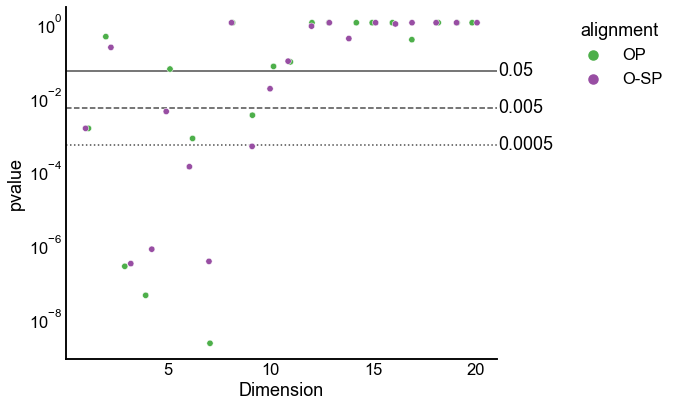

In [11]:


def plot_pvalues(results, line_locs=[0.05, 0.005, 0.0005]):
    results = results.copy()
    # jitter so we can see op vs o-sp
    results["n_components"] += np.random.uniform(-0.2, 0.2, size=len(results))

    styles = ["-", "--", ":"]
    line_kws = dict(color="black", alpha=0.7, linewidth=1.5, zorder=-1)

    # plot p-values by embedding dimension
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    sns.scatterplot(
        data=results,
        x="n_components",
        y="pvalue",
        hue="alignment",
        palette=palette,
        ax=ax,
        s=40,
    )
    ax.set_yscale("log")
    styles = ["-", "--", ":"]
    line_kws = dict(color="black", alpha=0.7, linewidth=1.5, zorder=-1)
    for loc, style in zip(line_locs, styles):
        ax.axhline(loc, linestyle=style, **line_kws)
        ax.text(ax.get_xlim()[-1] + 0.1, loc, loc, ha="left", va="center")
    ax.set(xlabel="Dimension")
    ax.get_legend().remove()
    ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left", title="alignment")
    plt.tight_layout()


plot_pvalues(results)
stashfig(
    f"naive-pvalues-test={test}-n_bootstraps={n_bootstraps}-preprocess={preprocess}"
)

### Not what we expected
It is worrisome that the p-values change drastically when the embedding dimension
changes slightly.

Below, we investigate what could be causing this phenomenon.

## Focus on the d=1 case
Note that in the testing above, even for $d=1$, the latent positions were significantly
different. Is this a bug? Or how can we explain this?

### Set up some metadata for this experiment

In [12]:
left_arange = np.arange(n_pairs)
right_arange = left_arange + n_pairs
embedding_1d_df = pd.DataFrame(index=np.arange(2 * n_pairs))
embedding_1d_df["pair_ind"] = np.concatenate((left_arange, left_arange))
embedding_1d_df["hemisphere"] = "Right"
embedding_1d_df.loc[left_arange, "hemisphere"] = "Left"
embedding_1d_df["x"] = 1
embedding_1d_df.loc[left_arange, "x"] = 0

### Align and test the d=1, out embedding
Just like in the 2-sample testing above, we take the $d=1$ embedding, align the left
to the right, and ask whether these embeddings are different. Here I only use the
out latent positions.

In [13]:
n_components = 1
op_left_out_latent, sp_left_out_latent = run_alignments(
    left_out_latent[:, :n_components], right_out_latent[:, :n_components]
)
embedding_1d_df.loc[left_arange, "out_1d_align"] = op_left_out_latent[:, 0]
embedding_1d_df.loc[right_arange, "out_1d_align"] = right_out_latent[:, 0]

dcorr_results_1d_align = run_test(op_left_out_latent[:, :1], right_out_latent[:, :1])
ks_results_1d_align = ks_2samp(op_left_out_latent[:, 0], right_out_latent[:, 0])

print("DCorr 2-sample test on first out dimension, aligned in 1D:")
print(f"p-value = {dcorr_results_1d_align['pvalue']:0.4f}")

print("KS 2-sample test on first out dimension, aligned in 1D:")
print(f"p-value = {ks_results_1d_align[1]:0.4f}")

DCorr 2-sample test on first out dimension, aligned in 1D:
p-value = 0.0142
KS 2-sample test on first out dimension, aligned in 1D:
p-value = 0.0049


### Align the $d=8$ out embedding, test on the first dimension
Now, we instead perform the alignment in the $d=8$ embedding. Then, we again look at
only the first dimension *of that aligned set of embeddings* and test whether those
are different.

In [14]:
n_components = 8
op_left_out_latent, sp_left_out_latent = run_alignments(
    left_out_latent[:, :n_components], right_out_latent[:, :n_components]
)

embedding_1d_df.loc[left_arange, "out_8d_align"] = op_left_out_latent[:, 0]
embedding_1d_df.loc[right_arange, "out_8d_align"] = right_out_latent[:, 0]

dcorr_results_8d_align = run_test(op_left_out_latent[:, :1], right_out_latent[:, :1])

ks_results_8d_align = ks_2samp(op_left_out_latent[:, 0], right_out_latent[:, 0])

print("DCorr 2-sample test on first out dimension, aligned in 8D:")
print(f"p-value = {dcorr_results_1d_align['pvalue']:0.4f}")

print("KS 2-sample test on first out dimension, aligned in 8D:")
print(f"p-value = {ks_results_1d_align[1]:0.4f}")

DCorr 2-sample test on first out dimension, aligned in 8D:
p-value = 0.0142
KS 2-sample test on first out dimension, aligned in 8D:
p-value = 0.0049


### Plot the results for testing on the first dimension only
Below are empirical CDFs for the first dimension, in both of the cases described above.
Note that in either case, the right embedding is the same, because we aligned left to
right.

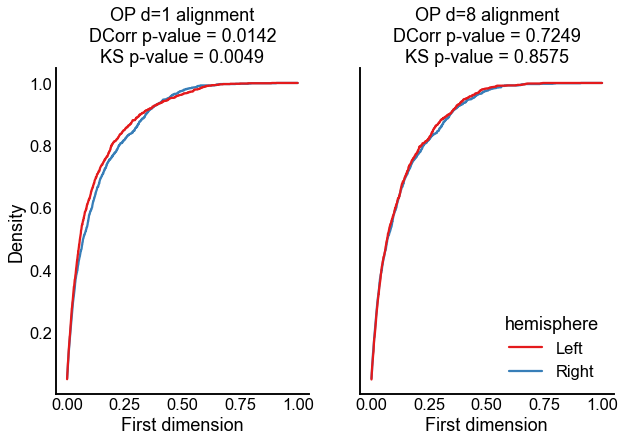

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
histplot_kws = dict(
    stat="density",
    cumulative=True,
    element="poly",
    common_norm=False,
    bins=np.linspace(0, 1, 2000),
    fill=False,
)

ax = axs[0]
sns.histplot(
    data=embedding_1d_df,
    x="out_1d_align",
    ax=ax,
    hue="hemisphere",
    legend=False,
    palette=palette,
    **histplot_kws,
)
title = "OP d=1 alignment"
title += f"\nDCorr p-value = {dcorr_results_1d_align['pvalue']:0.4f}"
title += f"\nKS p-value = {ks_results_1d_align[1]:0.4f}"
ax.set(title=title, xlabel="First dimension")

ax = axs[1]
sns.histplot(
    data=embedding_1d_df,
    x="out_8d_align",
    ax=ax,
    hue="hemisphere",
    palette=palette,
    **histplot_kws,
)
title = "OP d=8 alignment"
title += f"\nDCorr p-value = {dcorr_results_8d_align['pvalue']:0.4f}"
title += f"\nKS p-value = {ks_results_8d_align[1]:0.4f}"
ax.set(title=title, xlabel="First dimension")
stashfig(f"dim1-focus-test={test}-n_bootstraps={n_bootstraps}-preprocess={preprocess}")

## A "corrected" version of this test
We saw above that the alignment makes a huge difference in the outcome of the test.
One possible way to "fix" this is to use a higher embedding dimension whether the
alignment is good, and then perform our test for varying numbers of kept dimensions
(just like we did above where we aligned in $d=8$ and tested the first $d=1$
dimensions).

In [16]:
align_n_components = (
    12  # this is one of the dimensions where we failed to reject before
)
op_left_out_latent, sp_left_out_latent = run_alignments(
    left_out_latent[:, :align_n_components], right_out_latent[:, :align_n_components]
)
op_left_in_latent, sp_left_in_latent = run_alignments(
    left_in_latent[:, :align_n_components], right_in_latent[:, :align_n_components]
)
rows = []
for n_components in np.arange(1, align_n_components + 1):
    left_out = op_left_out_latent.copy()[:, :n_components]
    left_in = op_left_in_latent.copy()[:, :n_components]
    right_out = right_out_latent[:, :align_n_components].copy()[:, :n_components]
    right_in = right_in_latent[:, :align_n_components].copy()[:, :n_components]

    left_composite_latent = np.concatenate((left_out, left_in), axis=1)
    right_composite_latent = np.concatenate((right_out, right_in), axis=1)

    run_test(
        left_composite_latent,
        right_composite_latent,
        rows,
        info={"alignment": "OP", "n_components": n_components},
    )

corrected_results = pd.DataFrame(rows)

### Plot the results of the corrected version which starts from a good alignment
Here I plot the results only for orthogonal Procrustes. The behavior of the p-values
is much closer to what we would have expected.

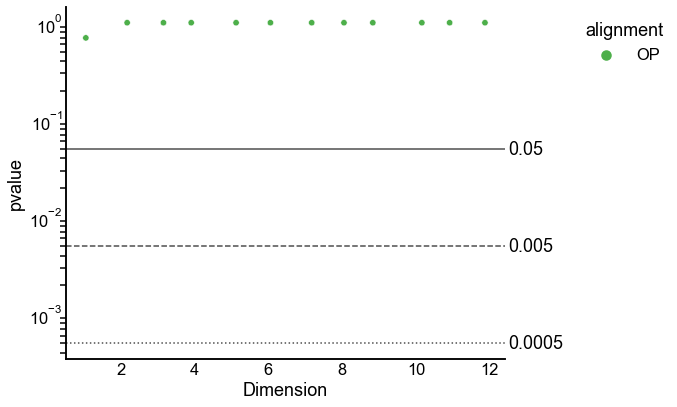

In [17]:
plot_pvalues(corrected_results)

## End

In [18]:
elapsed = time.time() - t0
delta = timedelta(seconds=elapsed)
print("----")
print(f"{delta} elapsed for whole script.")
print("----")

----
0:13:07.702549 elapsed for whole script.
----
